"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

In [ ]:
import pandas as pd

# Load the dataset
file_path = 'https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())


         Date    Open    High     Low    Last   Close  Total Trade Quantity  \
0  2018-09-28  234.05  235.95  230.20  233.50  233.75               3069914   
1  2018-09-27  234.55  236.80  231.10  233.80  233.25               5082859   
2  2018-09-26  240.00  240.00  232.50  235.00  234.25               2240909   
3  2018-09-25  233.30  236.75  232.00  236.25  236.10               2349368   
4  2018-09-24  233.55  239.20  230.75  234.00  233.30               3423509   

   Turnover (Lacs)  
0          7162.35  
1         11859.95  
2          5248.60  
3          5503.90  
4          7999.55  


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Keep only 'Date' and 'Close' columns
data = data[['Date', 'Close']]

# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set 'Date' as the index
data.set_index('Date', inplace=True)

# Normalize the 'Close' data (ONLY 'Close', not 'Date')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Convert the normalized data back to a DataFrame
scaled_data = pd.DataFrame(scaled_data, columns=['Close'], index=data.index)

print(scaled_data.head())


               Close
Date                
2018-09-28  0.624183
2018-09-27  0.622141
2018-09-26  0.626225
2018-09-25  0.633783
2018-09-24  0.622345


<ipython-input-3-50cf14e2361b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


In [ ]:
import numpy as np

# Define a function to create sequences
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
    return np.array(sequences)

# Define the sequence length
sequence_length = 60

# Create sequences
sequences = create_sequences(scaled_data.values, sequence_length)

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(sequences) * 0.8)
train_sequences = sequences[:train_size]
test_sequences = sequences[train_size:]

# Split sequences into features (X) and target (y)
X_train = train_sequences[:, :-1, :]
y_train = train_sequences[:, -1, :]
X_test = test_sequences[:, :-1, :]
y_test = test_sequences[:, -1, :]

print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')


X_train shape: (1580, 59, 1), y_train shape: (1580, 1)
X_test shape: (395, 59, 1), y_test shape: (395, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()

# First LSTM layer with Dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second LSTM layer with Dropout
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer with Dropout
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

print(model.summary())

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 59, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 59, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 59, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 59, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - loss: 0.0575 - val_loss: 0.0010
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0036 - val_loss: 9.1650e-04
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0035 - val_loss: 8.7050e-04
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 0.0028 - val_loss: 8.3980e-04
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0027 - val_loss: 8.2822e-04
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0030 - val_loss: 7.9202e-04
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - loss: 0.0026 - val_loss: 7.6092e-04
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0034 - val_loss: 7.7459e-04
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0026 - val_loss: 8.3176e-04
Epoch 12/50
40/40 ━━━━

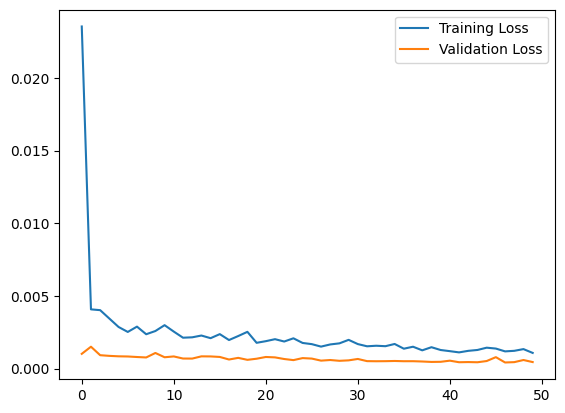

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
[[121.38558 ]
 [121.445335]
 [121.704414]
 [122.05952 ]
 [122.471596]]
***********************
[[120.9 ]
 [121.  ]
 [120.8 ]
 [121.45]
 [118.95]]


In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and test data to get the original scale
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

print(predictions[:5])

print('***********************')

print(y_test[:5])


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 4.793094107622259


In [ ]:
# Save the model
model.save('stock_prediction_lstm_model.h5')


Summary of the Project:
This project is about predicting future stock prices using a Long Short-Term Memory (LSTM) neural network, a type of Recurrent Neural Network (RNN) that is effective for time-series forecasting.


Data Preparation:


We first load the stock price data.
The 'Date' column is converted to datetime format and set as the index.
We normalize the 'Close' prices to ensure they are within the range of 0 to 1, making the data suitable for neural network training.
Creating Sequences:

We define a sequence length of 60, meaning we use 60 days of data to predict the next day's stock price.
The data is split into training and testing sets with an 80-20 ratio.
Building the LSTM Model:

An LSTM model is constructed with three LSTM layers, each followed by a Dropout layer to prevent overfitting.
The model is trained using the Adam optimizer and mean squared error loss function.


Evaluation:

We plot the training and validation loss to visualize the model's performance during training.
Predictions are made on the test set, and the results are transformed back to the original scale.
The model's accuracy is evaluated using the Root Mean Squared Error (RMSE).
Model Saving:


The trained model is saved for future use.
This project demonstrates a practical application of LSTM networks for time series prediction, specifically stock price forecasting.